# Application showing the interpolation of a single species: _Biddulphia Sinensis_
The interpolation of the full dataset (loop, plots and netCDF generation) is performed in [`interp_presence_absence_prod`](interp_presence_absence_prod.ipynb)

In [1]:
using DIVAnd
using PyPlot
using Proj4
using DelimitedFiles
using PyCall
using Dates
using NCDatasets
include("../scripts/PhytoInterp.jl")
doplot = true

true

## Files and directories

In [2]:
figdir = "../product/figures/"
outputdir = "../product/"
datadir = "../data/"
datafile = joinpath(datadir, "Biddulphia sinensis-1995-2020.csv")
isdir(datadir) ? " " : mkpath(datadir)
isdir(figdir) ? " " : mkpath(figdir)
isfile(datafile) ? @info("File already downloaded") : download("https://dox.ulg.ac.be/index.php/s/VgLglubaTLetHzc/download", datafile)

┌ Info: File already downloaded
└ @ Main In[2]:7


## Prepare mask
### Interpolation grid

In [3]:
longrid = -2.:0.1:10.
latgrid = 51.:0.1:56.

51.0:0.1:56.0

### Download file

In [14]:
bathname = joinpath(datadir, "gebco_30sec_4.nc")
if !isfile(bathname)
    download("https://dox.ulg.ac.be/index.php/s/RSwm4HPHImdZoQP/download", bathname)
else
    @info("Bathymetry file already downloaded")
end

"../data/gebco_30sec_4.nc"

### Read bathymetry

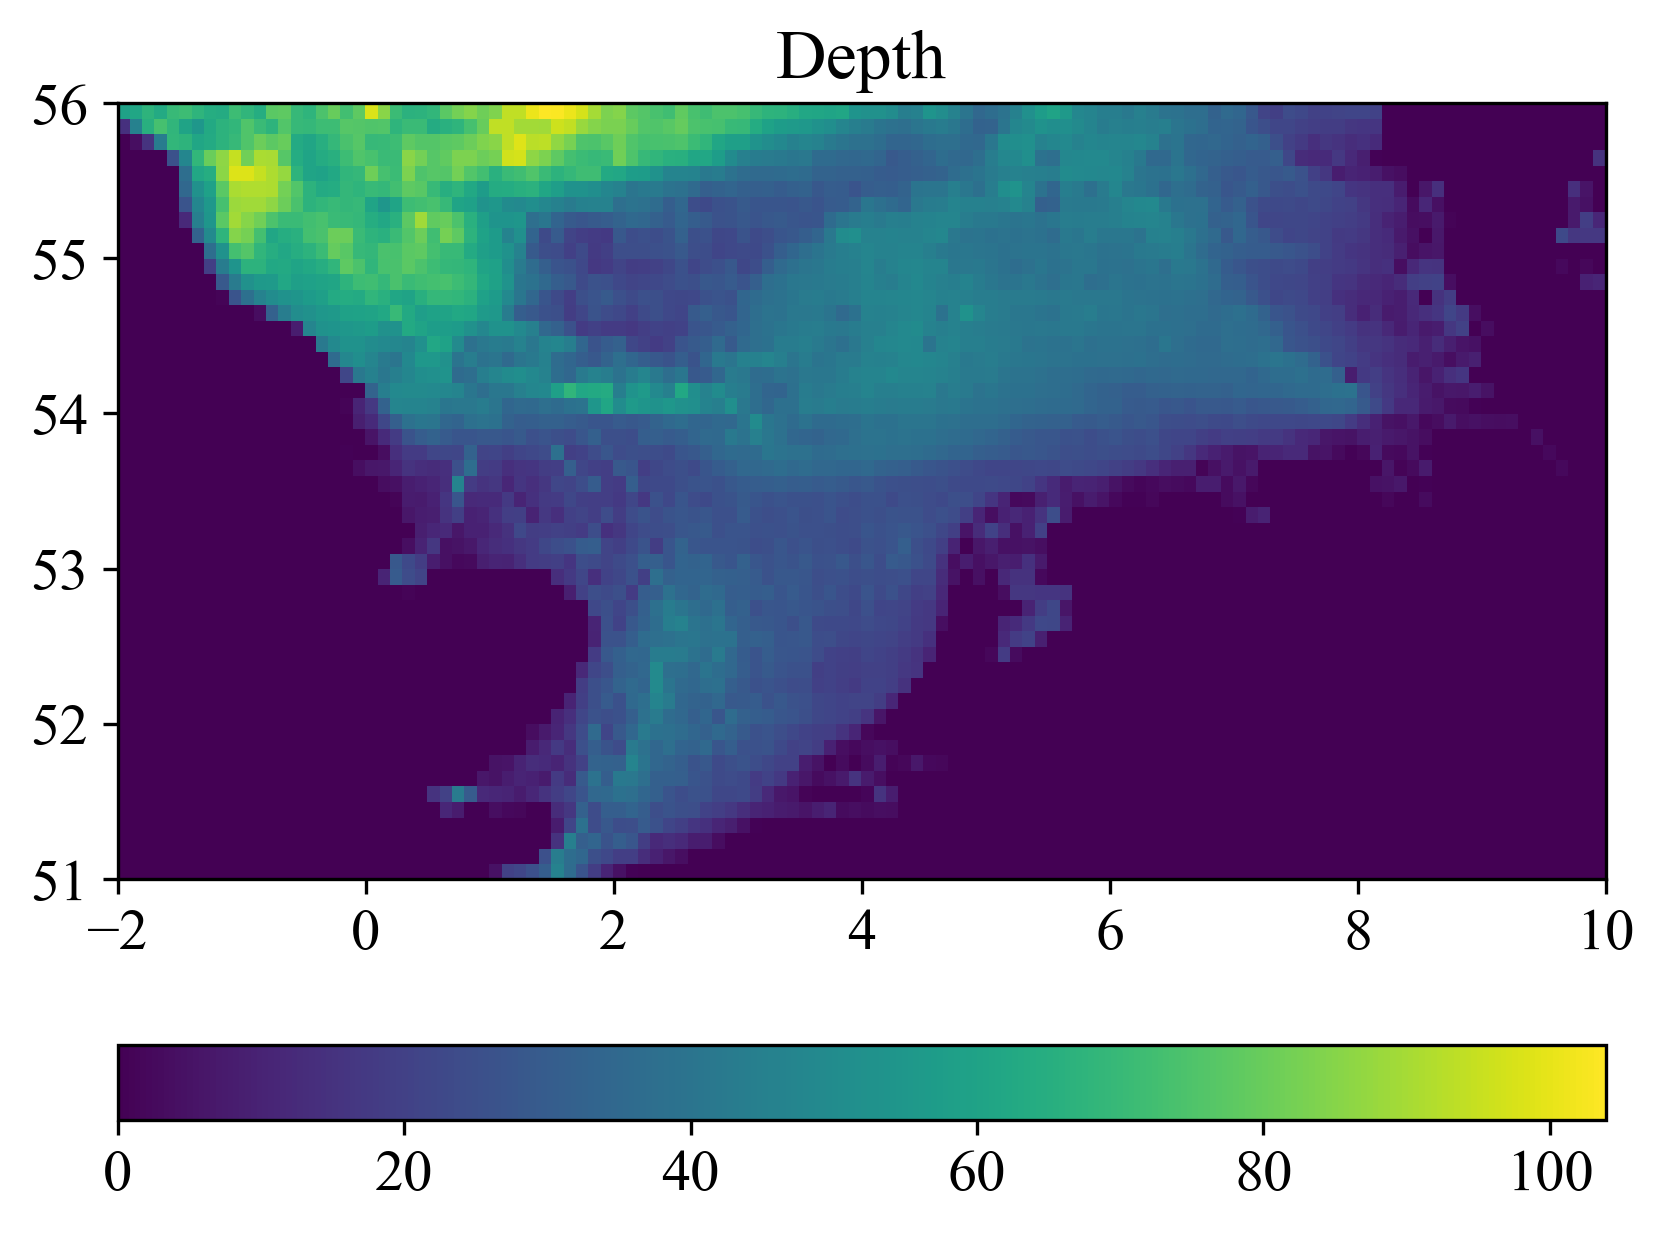

size(b) = (121, 51)


In [15]:
bx, by, b = load_bath(bathname, true, longrid, latgrid)
@show size(b)

if doplot
    fig = PyPlot.figure()
    ax = PyPlot.subplot(111)
    pcolor(bx,by,b', vmin=0.); 
    colorbar(orientation="horizontal")
    title("Depth")
    show()
end

### Metrics

In [16]:
mask, (pm, pn),(xi, yi) = DIVAnd.DIVAnd_rectdom(longrid, latgrid);
xi, yi, mask = DIVAnd.load_mask(bathname, true, longrid, latgrid, 0.0);
xx, yy = ndgrid(xi, yi);

## Interpolation

In [17]:
speciesname = get_species_name(basename(datafile))
speciesslug = get_species_slug(basename(datafile))
@info("Working on $(speciesname)")
        
# Data reading
dates, lons, lats, occurs = read_data_phyto(datafile);

# Conversion of coordinates
lon, lat = transform_coords(lons, lats)

data_presence = occurs .== 1;
data_absence = .!(data_presence);
npre = sum(data_presence)
nabs = sum(data_absence);
@info("Presence: $(npre), absence: $(nabs)");

┌ Info: Working on Biddulphia sinensis
└ @ Main In[17]:3
┌ Info: Presence: 6957, absence: 18820
└ @ Main In[17]:15


### Compute heatmap
We compute: 
1. the heatmap using all the observation (presence or absence),
2. the heatmap using only the presence observations,
3. the heatmap only the absence observations.

The first provides an indication of the sampling effort: high values in an area means a lot of measurements have been made in that area.

In [23]:
inflation = ones(length(lon));
@time dens1, LHM1, LCV1, LSCV1 = DIVAnd_heatmap(mask, (pm,pn), (xx, yy), 
    (lon, lat), inflation, 0.2);
@time dens2, LHM2, LCV2, LSCV2 = DIVAnd_heatmap(mask, (pm,pn), (xx, yy), 
    (lon[data_presence], lat[data_presence]), inflation[data_presence], 0.2);
@time dens3, LHM3, LCV3, LSCV3 = DIVAnd_heatmap(mask, (pm,pn), (xx, yy), 
    (lon[data_absence], lat[data_absence]), inflation[data_absence], 0.2);

┌ Warning: Data array size (25777,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


  1.142954 seconds (928.38 k allocations: 1.171 GiB, 4.46% gc time)
  4.177570 seconds (621.36 k allocations: 4.755 GiB, 4.26% gc time)


┌ Warning: Data array size (18820,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


  0.974854 seconds (698.74 k allocations: 1.013 GiB, 3.90% gc time)


Finally, the probability field is computed as:
```
d = npre * dens2 / (npre * dens2 + nabs * dens3)
```
The reason for this equation is that the heatmap are computed so that their integral over the domain is 1, whatever the number of observations. 

In [22]:
d = npre .* dens2 ./ (npre .* dens2 .+ nabs .* dens3);

### Plotting

In [10]:
if doplot
    plot_heatmap(longrid, latgrid, d, lon, lat, occurs,
        "$(speciesname): normalised heatmap")
    pcolormesh(longrid, latgrid, mask', cmap=PyPlot.cm.binary_r)
end

UndefVarError: UndefVarError: d not defined

### Write results in netCDF

In [11]:
create_nc_results(joinpath(outputdir, "$(speciesname)_heatmap.nc"), 
    longrid, latgrid, d, speciesname);

UndefVarError: UndefVarError: d not defined